### Feature Engineering - Application Data

Let's look at correlations, and attempt to apply some simple domain knowledge to create better features.

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import visuals as vs

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

# Show all of the data in a dataframe
pd.set_option('display.max_columns', None)

In [2]:
# Training Set
application_train = pd.read_csv('data/tmp/application_train_full_new_features.csv', index_col = 0)
print("Loaded Training Set: {0} rows".format(application_train.shape[0]))

application_test = pd.read_csv('data/tmp/application_test_full_new_features.csv', index_col = 0)
print("Loaded Training Set: {0} rows".format(application_test.shape[0]))

display(application_train.head())

Loaded Training Set: 307511 rows
Loaded Training Set: 48744 rows


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,BOOL_FLAG_EMAIL,BOOL_FLAG_EMP_PHONE,BOOL_FLAG_OWN_CAR,BOOL_FLAG_OWN_REALTY,BOOL_FLAG_PHONE,BOOL_FLAG_WORK_PHONE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_MOBIL,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START_0,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_12,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_14,HOUR_APPR_PROCESS_START_15,HOUR_APPR_PROCESS_START_16,HOUR_APPR_PROCESS_START_17,HOUR_APPR_PROCESS_START_18,HOUR_APPR_PROCESS_START_19,HOUR_APPR_PROCESS_START_2,HOUR_APPR_PROCESS_START_20,HOUR_APPR_PROCESS_START_21,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_5,HOUR_APPR_PROCESS_START_6,HOUR_APPR_PROCESS_START_7,HOUR_APPR_PROCESS_START_8,HOUR_APPR_PROCESS_START_9,HOUSETYPE_MODE_not specified,HOUSETYPE_MODE_org spec account,HOUSETYPE_MODE_reg oper account,HOUSETYPE_MODE_reg oper spec account,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUP

In [3]:
# Load the list of features indentified in the exploration step which need preprocessing
non_numeric_features = pd.read_csv('data/tmp/non_numeric_features.csv', header=0, index_col=0, names=["feature"])
numeric_features = pd.read_csv('data/tmp/numeric_features.csv', header=0, index_col=0, names=["feature"])
string_to_bool_features = pd.read_csv('data/tmp/string_to_bool.csv', header=0, index_col=0, names=["feature"])
log_transform_features = pd.read_csv('data/tmp/log_transform.csv', header=0, index_col=0, names=["feature"])
important_features = pd.read_csv('data/tmp/bureau_important_fields.csv', index_col = 0)
display(important_features.head())

,features
0,EXT_SOURCE_2
1,AMT_ANNUITY
2,EXT_SOURCE_3
3,AMT_CREDIT
4,EXT_SOURCE_1


In [4]:
def get_prediction_performance(dataFrame, target=None): 
    
    df = dataFrame.copy()
    
    # https://stackoverflow.com/questions/24870306/how-to-check-if-a-column-exists-in-pandas 
    if 'TARGET' in df: 
        target = df['TARGET']
        df = df.drop('TARGET',axis=1)

    if 'SK_ID_CURR' in df: 
        df = df.drop('SK_ID_CURR', axis=1)
    
    # Make a test and train set
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

    dtc = DecisionTreeClassifier(criterion='entropy', max_depth=1, max_features='auto', random_state=42)
    clf = AdaBoostClassifier(base_estimator=dtc, algorithm='SAMME.R', n_estimators = 500, random_state=42)
    clf.fit(X_train, y_train) 
    
    predictions = clf.predict(X_test)
    score = roc_auc_score(y_test, predictions)
    
    return score    

#### Correlations

In [5]:
correlations = application_train.corr()['TARGET'].sort_values()

In [6]:
print("Top 10 Positive Correlations\n{0}\n".format(correlations.head(n=20)))
print("Top 10 Negative Correlations\n{0}\n".format(correlations.tail(n=20)))

Top 10 Positive Correlations
EXT_SOURCE_2                                   -0.160303
EXT_SOURCE_3                                   -0.157397
EXT_SOURCE_1                                   -0.099152
EXT_SOURCE_2_X_AMT_CREDIT_X_AMT_GOODS_PRICE    -0.085807
EXT_SOURCE_2_X_AMT_GOODS_PRICE_X_AMT_ANNUITY   -0.079273
DAYS_BIRTH                                     -0.078239
DAYS_EMPLOYED                                  -0.057159
NAME_EDUCATION_TYPE_Higher education           -0.056593
DAYS_LAST_PHONE_CHANGE                         -0.055006
CODE_GENDER_F                                  -0.054704
DAYS_ID_PUBLISH                                -0.051457
NAME_INCOME_TYPE_Pensioner                     -0.046209
ORGANIZATION_TYPE_XNA                          -0.045987
EMERGENCYSTATE_MODE_No                         -0.042201
DAYS_REGISTRATION                              -0.041421
REGION_POPULATION_RELATIVE                     -0.037227
WALLSMATERIAL_MODE_Panel                       -0.033119
AM

In [7]:
# Grab the feature names of the 10 most and least correlated features
hc_features = correlations.index
highly_correlated = list(hc_features[:10])
highly_correlated.extend(list(hc_features[-10:]))

df_hc = application_train[highly_correlated]

In [8]:
hc_corr = df_hc.corr()

#### Correlation Heatmap

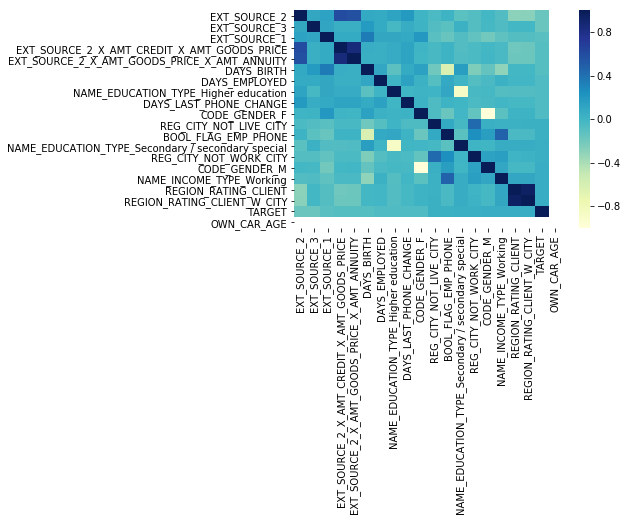

In [9]:
ax = sns.heatmap(hc_corr, cmap="YlGnBu")

#### Observations 

Strong negative correlations between the following  
    - Higher Education vs. Secondary/Special  (Better Education = Better Job)
    - Female vs Male (Women are more responsible)
    - Age and EMPLOYER_PHONE (Product of Age and Employment Status)
    
Strong positive correlations between: 
    - REG_CITY_NOT_WORK_CITY vs REG_CITY_NOT_LIVE_CITY (Long commute to job = more likely to quit/have problems)
    - Income Type: Working vs Flag Emp Phone (Working and provided evidence to prove it == more confidence)
    - Flag Emp Phone vs Flag Doc 3 (Employed and provided some proprietary documentation == more confidence)
    - Days ID Publish vs Age (Age and Established Identity == more confidence that this isn't a fraudulent identity)

#### Correlation Scatter Matrix

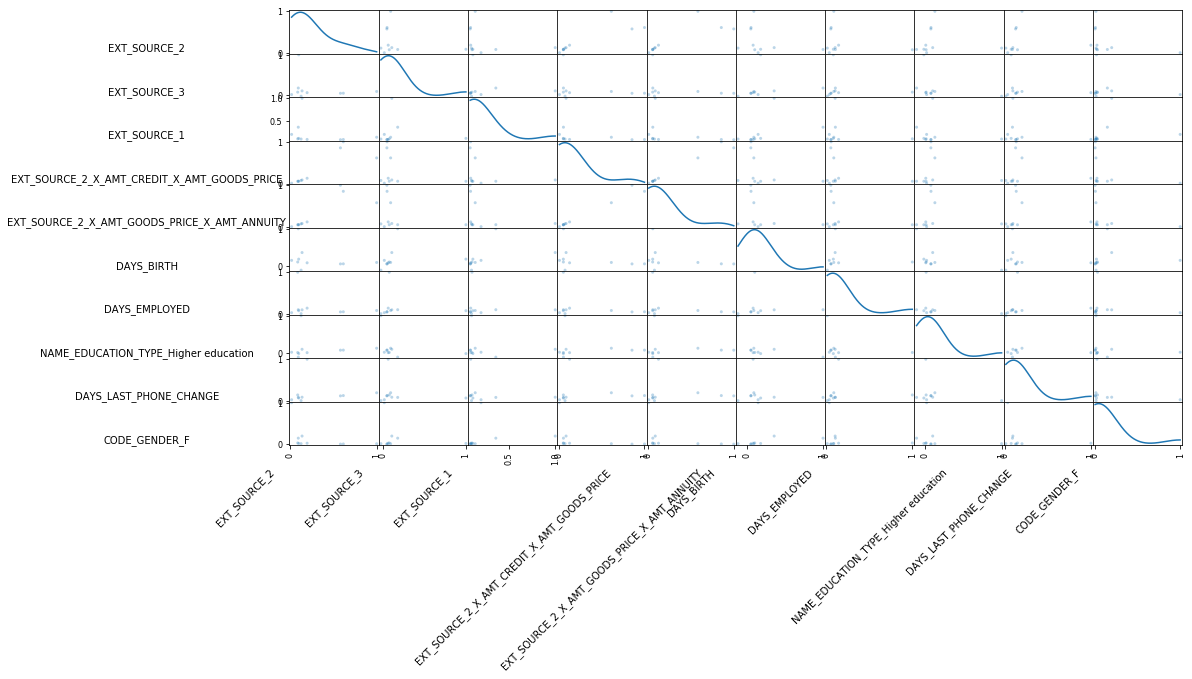

In [10]:
df_hc_top_10 = application_train[highly_correlated[:10]]
df_hc_top_10_corr = df_hc_top_10.corr()

# From customer segments project
from pandas.plotting import scatter_matrix
sm = scatter_matrix(df_hc_top_10_corr, alpha = 0.3, figsize = (16,8), diagonal = 'kde');

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1.6,0) for s in sm.reshape(-1)]
[s.get_xaxis().set_label_coords(-.5,-.5) for s in sm.reshape(-1)]

plt.show()

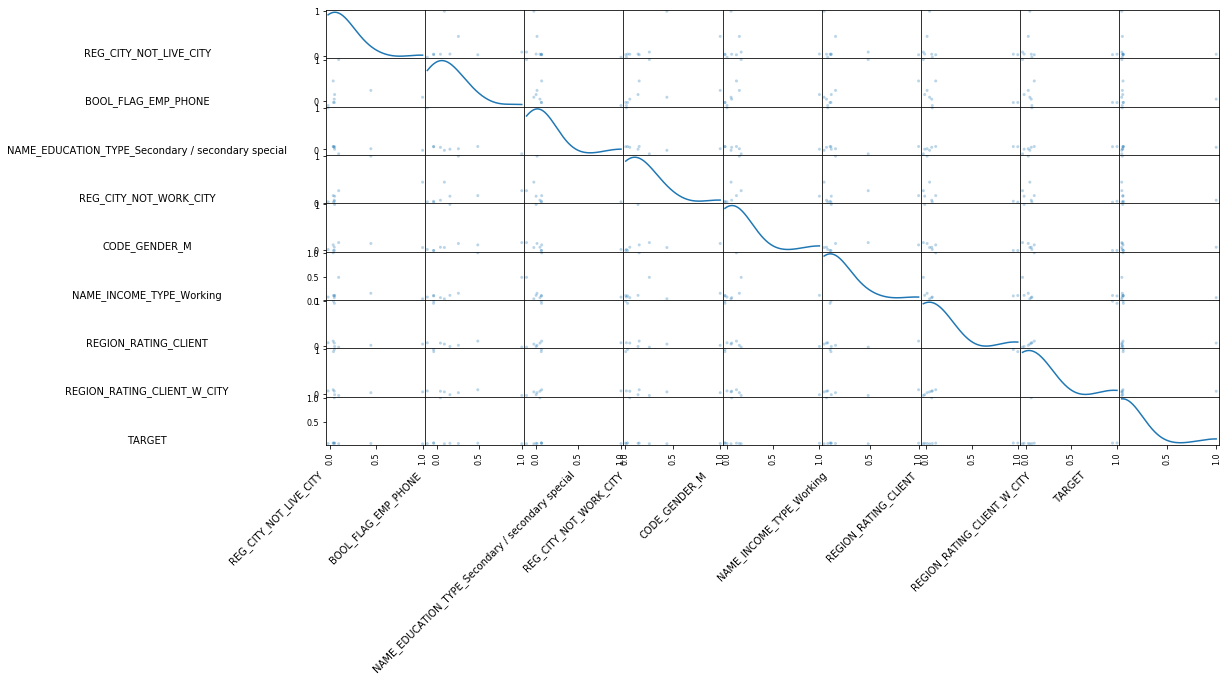

In [11]:
# OWN_CAR_AGE correlation of NaN, which the plot doesn't like.... 
df_hc_bot_10 = application_train[highly_correlated[10:19]]
df_hc_bot_10_corr = df_hc_bot_10.corr()

# From customer segments project
sm = scatter_matrix(df_hc_bot_10_corr, alpha = 0.3, figsize = (16,8), diagonal = 'kde');

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1.8,0) for s in sm.reshape(-1)]
[s.get_xaxis().set_label_coords(-.5,-.5) for s in sm.reshape(-1)]

plt.show()

#### Observations

The following have an interesting impact on distributions: 
- DAYS_LAST_PHONE_CHANGE
- Higher Education
- Age
- BOOL_FLAG_EMP_PHONE
- REG_CITY_NOT_WORK_CITY
- FLAG_DOCUMENT_3

### Revisiting Primary Component Analysis

Considering both our highly correlated and important faatures, I wonder if we can come up with more interesting PCA results

In [12]:
application_train_reduced = application_train[important_features['features'][:10]].copy()
target_train = application_train['TARGET']
display(target_train.head())

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

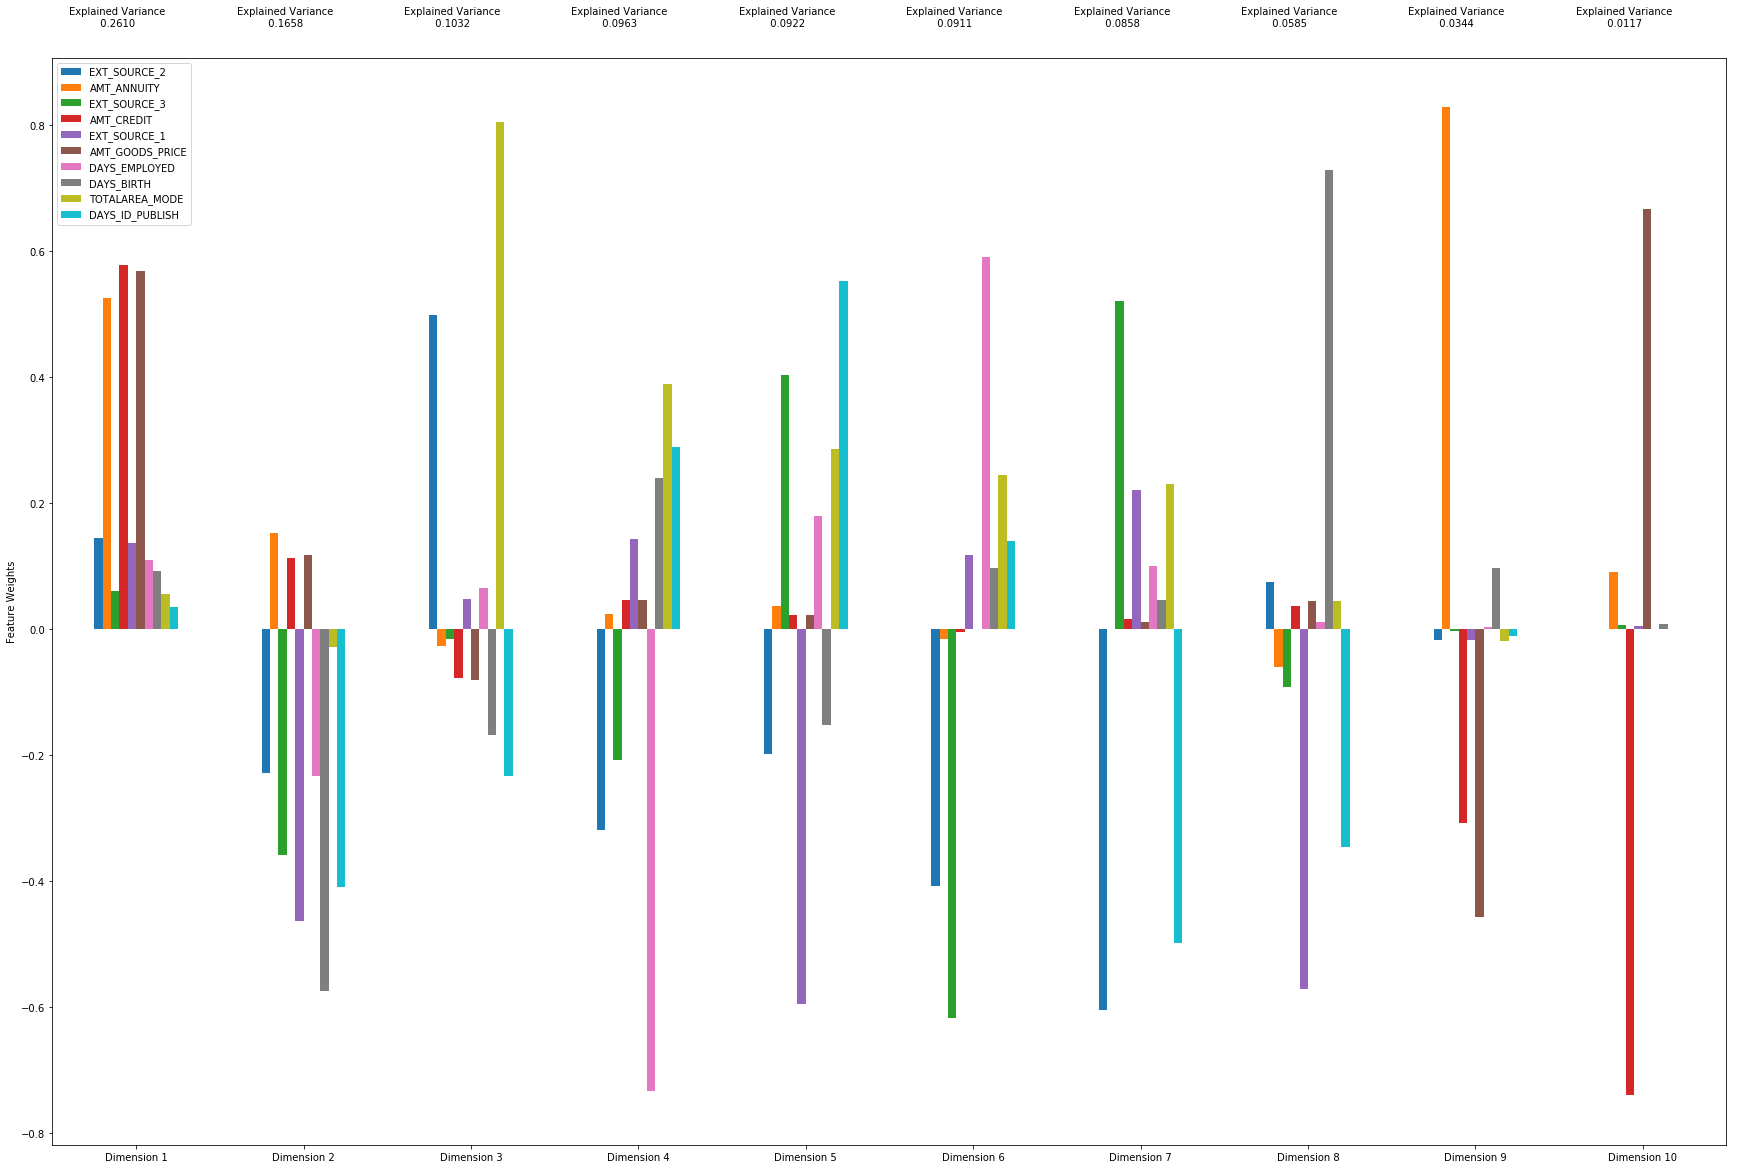

In [13]:
from sklearn.decomposition import PCA

good_data = application_train_reduced

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=10)
pca.fit(application_train_reduced)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(application_train_reduced)

def pca_results(pca_samples, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (30,20))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

# Generate PCA results plot
pca_results = pca_results(pca_samples, pca)

#### Dimension 1

This dimension explains 26.1% of the variance, and is dominated by AMT_CREDIT (the amount of the loan), AMT_GOODS_PRICE (for commercial loans, the amount of the item purchased) and AMT_ANNUITY (the annual payment).  

It would be interesting to see if I can synthesize better features, like ANNUITY and CREDIT as a percentage of INCOME)

In [14]:
df_new_features_train = application_train.copy()
df_new_features_train_SK_ID_CURR = df_new_features_train['SK_ID_CURR']
df_new_features_train = df_new_features_train.drop(['SK_ID_CURR','TARGET'], axis=1)

df_new_features_test = application_test.copy()
df_new_features_test_SK_ID_CURR = df_new_features_test['SK_ID_CURR']
df_new_features_test = df_new_features_test.drop(['SK_ID_CURR'], axis=1)

df_new_reduced_train = df_new_features_train[important_features['features']].copy()
df_new_reduced_test = df_new_features_test[important_features['features']].copy()

# We need these values to be positive when calculating percentages.... 
df_temp_train = pd.DataFrame()
df_temp_train['AMT_CREDIT_OFFSET'] = df_new_features_train['AMT_CREDIT'] + np.min(df_new_features_train['AMT_CREDIT'])
df_temp_train['AMT_INCOME_TOTAL_OFFSET'] = df_new_features_train['AMT_INCOME_TOTAL'] + np.min(df_new_features_train['AMT_INCOME_TOTAL'])
df_temp_train['AMT_GOODS_PRICE_OFFSET'] = df_new_features_train['AMT_GOODS_PRICE'] + np.min(df_new_features_train['AMT_GOODS_PRICE'])
df_temp_train['AMT_ANNUITY_OFFSET'] = df_new_features_train['AMT_ANNUITY'] + np.min(df_new_features_train['AMT_ANNUITY'])

df_temp_test = pd.DataFrame()
df_temp_test['AMT_CREDIT_OFFSET'] = df_new_features_test['AMT_CREDIT'] + np.min(df_new_features_test['AMT_CREDIT'])
df_temp_test['AMT_INCOME_TOTAL_OFFSET'] = df_new_features_test['AMT_INCOME_TOTAL'] + np.min(df_new_features_test['AMT_INCOME_TOTAL'])
df_temp_test['AMT_GOODS_PRICE_OFFSET'] = df_new_features_test['AMT_GOODS_PRICE'] + np.min(df_new_features_test['AMT_GOODS_PRICE'])
df_temp_test['AMT_ANNUITY_OFFSET'] = df_new_features_test['AMT_ANNUITY'] + np.min(df_new_features_test['AMT_ANNUITY'])

# Loan amount as percentage of total income
df_new_features_train['PER_CREDIT_INCOME'] = df_temp_train['AMT_CREDIT_OFFSET'] / df_temp_train['AMT_INCOME_TOTAL_OFFSET']
df_new_reduced_train['PER_CREDIT_INCOME'] = df_temp_train['AMT_CREDIT_OFFSET'] / df_temp_train['AMT_INCOME_TOTAL_OFFSET']

df_new_features_test['PER_CREDIT_INCOME'] = df_temp_test['AMT_CREDIT_OFFSET'] / df_temp_test['AMT_INCOME_TOTAL_OFFSET']
df_new_reduced_test['PER_CREDIT_INCOME'] = df_temp_test['AMT_CREDIT_OFFSET'] / df_temp_test['AMT_INCOME_TOTAL_OFFSET']

# Cost of Goods as a percentage of the loan (I suspect this will be 1 all the time)
df_new_features_train['PER_GOODS_CREDIT'] = df_temp_train['AMT_GOODS_PRICE_OFFSET'] / df_temp_train['AMT_CREDIT_OFFSET']
df_new_reduced_train['PER_GOODS_CREDIT'] = df_temp_train['AMT_GOODS_PRICE_OFFSET'] / df_temp_train['AMT_CREDIT_OFFSET']

df_new_features_test['PER_GOODS_CREDIT'] = df_temp_test['AMT_GOODS_PRICE_OFFSET'] / df_temp_test['AMT_CREDIT_OFFSET']
df_new_reduced_test['PER_GOODS_CREDIT'] = df_temp_test['AMT_GOODS_PRICE_OFFSET'] / df_temp_test['AMT_CREDIT_OFFSET']

# Loan payment as a percentage of total income
df_new_features_train['PER_ANNUITY_INCOME'] = df_temp_train['AMT_ANNUITY_OFFSET'] / df_temp_train['AMT_INCOME_TOTAL_OFFSET']
df_new_reduced_train['PER_ANNUITY_INCOME'] = df_temp_train['AMT_ANNUITY_OFFSET'] / df_temp_train['AMT_INCOME_TOTAL_OFFSET']

df_new_features_test['PER_ANNUITY_INCOME'] = df_temp_test['AMT_ANNUITY_OFFSET'] / df_temp_test['AMT_INCOME_TOTAL_OFFSET']
df_new_reduced_test['PER_ANNUITY_INCOME'] = df_temp_test['AMT_ANNUITY_OFFSET'] / df_temp_test['AMT_INCOME_TOTAL_OFFSET']

display(df_new_features_train.head())
display(df_new_features_test.head())

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,BOOL_FLAG_EMAIL,BOOL_FLAG_EMP_PHONE,BOOL_FLAG_OWN_CAR,BOOL_FLAG_OWN_REALTY,BOOL_FLAG_PHONE,BOOL_FLAG_WORK_PHONE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_MOBIL,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START_0,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_12,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_14,HOUR_APPR_PROCESS_START_15,HOUR_APPR_PROCESS_START_16,HOUR_APPR_PROCESS_START_17,HOUR_APPR_PROCESS_START_18,HOUR_APPR_PROCESS_START_19,HOUR_APPR_PROCESS_START_2,HOUR_APPR_PROCESS_START_20,HOUR_APPR_PROCESS_START_21,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_5,HOUR_APPR_PROCESS_START_6,HOUR_APPR_PROCESS_START_7,HOUR_APPR_PROCESS_START_8,HOUR_APPR_PROCESS_START_9,HOUSETYPE_MODE_not specified,HOUSETYPE_MODE_org spec account,HOUSETYPE_MODE_reg oper account,HOUSETYPE_MODE_reg oper spec account,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUP

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,BOOL_FLAG_EMAIL,BOOL_FLAG_EMP_PHONE,BOOL_FLAG_OWN_CAR,BOOL_FLAG_OWN_REALTY,BOOL_FLAG_PHONE,BOOL_FLAG_WORK_PHONE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_MOBIL,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START_0,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_12,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_14,HOUR_APPR_PROCESS_START_15,HOUR_APPR_PROCESS_START_16,HOUR_APPR_PROCESS_START_17,HOUR_APPR_PROCESS_START_18,HOUR_APPR_PROCESS_START_19,HOUR_APPR_PROCESS_START_2,HOUR_APPR_PROCESS_START_20,HOUR_APPR_PROCESS_START_21,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_5,HOUR_APPR_PROCESS_START_6,HOUR_APPR_PROCESS_START_7,HOUR_APPR_PROCESS_START_8,HOUR_APPR_PROCESS_START_9,HOUSETYPE_MODE_not specified,HOUSETYPE_MODE_org spec account,HOUSETYPE_MODE_reg oper account,HOUSETYPE_MODE_reg oper spec account,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUP

#### Look for prediction improvements

In [15]:
# Initialize a scaler, then apply it to the features
scaler = StandardScaler()

# Assemble a list of all numeric fields
numeric = [] 

for feature in log_transform_features['feature']:
    numeric.append("{0}".format(feature))

for feature in numeric_features['feature']: 
    numeric.append("{0}".format(feature))

set_a = set(numeric)
set_b = set(important_features['features'])
numeric = list(set_a.intersection(set_b))
numeric += ['PER_CREDIT_INCOME', 'PER_GOODS_CREDIT', 'PER_ANNUITY_INCOME']
    
# Initialize a scaler, then apply it to the features
scaler = StandardScaler()

scaler = scaler.fit(df_new_features_train[numeric])
df_new_features_test[numeric] = scaler.transform(df_new_features_test[numeric])
df_new_features_train[numeric] = scaler.transform(df_new_features_train[numeric])

scaler = scaler.fit(df_new_reduced_train[numeric])
df_new_reduced_test[numeric] = scaler.transform(df_new_reduced_test[numeric])
df_new_reduced_train[numeric] = scaler.transform(df_new_reduced_train[numeric])

#### Generate Benchmarks

In [16]:
get_prediction_performance(application_train_reduced, target_train)

0.5104830686876065

Baseline - Reduced Dataset: 0.5104830686876065

In [17]:
application_train_noID = application_train.copy()
application_train_noID = application_train_noID.drop('SK_ID_CURR', axis=1)
application_train_noID = application_train_noID.drop('TARGET', axis=1)

get_prediction_performance(application_train_noID, target_train)

0.5161028439797717

Baseline - Full Dataset: 0.5161028439797717

In [18]:
get_prediction_performance(df_new_reduced_train, target_train)

0.5122801573467769

New Features - Reduced Dataset: 0.5122801573467769

In [19]:
get_prediction_performance(df_new_features_train, target_train)

0.5166206159709185

New Features - Full Dataset: 0.5166206159709185

### Export

In [20]:
df_new_features_train['SK_ID_CURR'] = application_train['SK_ID_CURR']
df_new_features_train['TARGET'] = target_train
df_new_features_test['SK_ID_CURR'] = application_test['SK_ID_CURR']

df_new_features_train.to_csv('data/tmp/application_train_full_engineered_features.csv')
df_new_features_test.to_csv('data/tmp/application_test_full_engineered_features.csv')